# Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.util import ngrams
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv('https://github.com/modos/ML-AI/raw/refs/heads/main/datasets/ml_hw3/finalSentimentdata2.csv')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')



country_names = ["italy", "uk", "usa", "china", "brazil", "vietnam", "us", "india", "bangladesh", "singapore"]
other_words = ["im", "world", "four_oclock", "pic", "hello", "tamilnadu", "trump", "say" "home", "going", "day", "lockdown", "due", "get", "officers", "kim"]

min_frequency = 5
max_frequency = 0.9 * len(data)

def preprocess_text(text, n=2):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\b(twitter)\b', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [w for w in tokens if w.lower() not in country_names]
    tokens = [w for w in tokens if w.lower() not in other_words]
    tokens = [w for w in tokens if not w in stop_words]

    text = " ".join(tokens)
    return text

data['processed_text'] = data['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


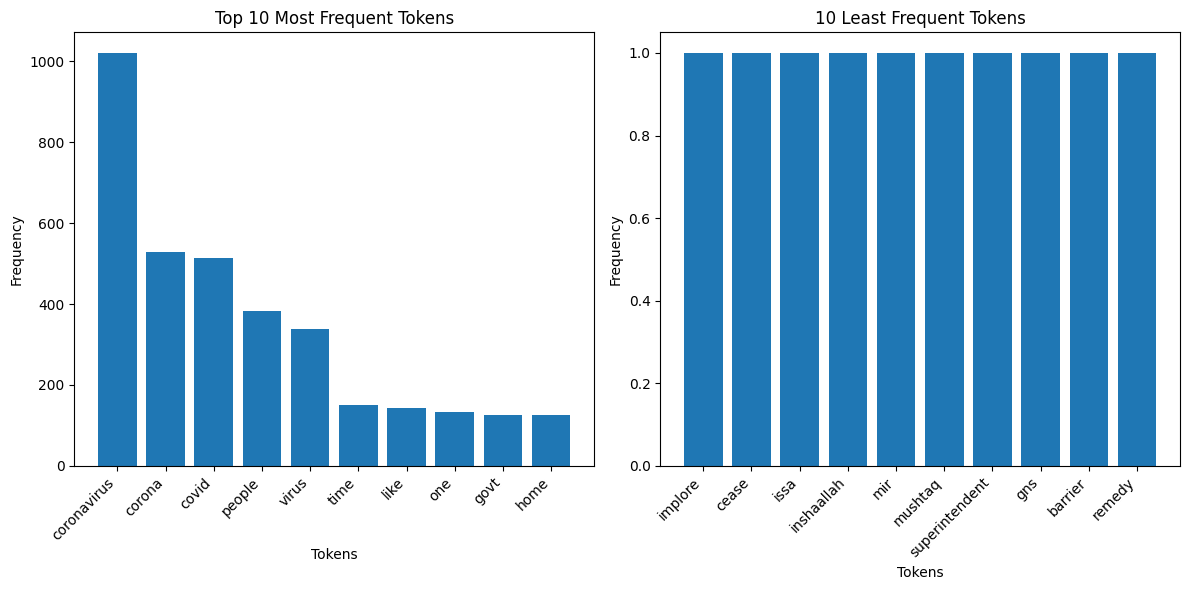

In [ ]:
dictionary = Dictionary([text.split() for text in data['processed_text']])
corpus = [dictionary.doc2bow(text.split()) for text in data['processed_text']]

frequency = defaultdict(int)
for text in data['processed_text']:
    for token in text.split():
        frequency[token] += 1

sorted_tokens = sorted(frequency.items(), key=lambda item: item[1], reverse=True)

top_10_tokens = sorted_tokens[:10]
least_10_tokens = sorted_tokens[-10:]


top_tokens_names = [token[0] for token in top_10_tokens]
top_tokens_freq = [token[1] for token in top_10_tokens]
least_tokens_names = [token[0] for token in least_10_tokens]
least_tokens_freq = [token[1] for token in least_10_tokens]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_tokens_names, top_tokens_freq)
plt.title('Top 10 Most Frequent Tokens')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(least_tokens_names, least_tokens_freq)
plt.title('10 Least Frequent Tokens')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
def simple_bayes_classifier(X_train, y_train, X_test, vocab):
    class_counts = {}
    word_counts = {}

    for i in range(len(X_train)):
        label = y_train[i]
        if label not in class_counts:
            class_counts[label] = 0
            word_counts[label] = defaultdict(int)
        class_counts[label] += 1
        for word in X_train[i]:
            word_counts[label][word] += 1

    predictions = []
    for document in X_test:
        probs = {}
        for label in class_counts:
            prob = np.log(class_counts[label] / len(X_train))
            for word in document:
                if word in vocab:
                  prob += np.log((word_counts[label][word] + 1) / (sum(word_counts[label].values()) + len(vocab)))
            probs[label] = prob

        predictions.append(max(probs, key=probs.get))
    return predictions


vector_sizes = range(100, 3000, 100)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
df = None

for vector_size in vector_sizes:
    top_tokens = [token[0] for token in sorted_tokens[:vector_size]]

    test_accuracy_scores = []
    test_f1_scores = []

    train_accuracy_scores = []
    train_f1_scores = []

    for train_index, test_index in kf.split(data):
        X_train = data.loc[train_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
        y_train = data.loc[train_index, 'sentiment'].to_list()
        X_test = data.loc[test_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
        y_test = data.loc[test_index, 'sentiment'].to_list()


        y_pred = simple_bayes_classifier(X_train, y_train, X_test, top_tokens)
        test_accuracy_scores.append(accuracy_score(y_test, y_pred))
        test_f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        y_train_pred = simple_bayes_classifier(X_train, y_train, X_train, top_tokens)
        train_accuracy_scores.append(accuracy_score(y_train, y_train_pred))
        train_f1_scores.append(f1_score(y_train, y_train_pred, average='weighted'))


    results.append({
        'vector_size': vector_size,
        'test_accuracy': np.mean(test_accuracy_scores),
        'test_f1_score': np.mean(test_f1_scores),
        'train_accuracy': np.mean(train_accuracy_scores),
        'train_f1_score': np.mean(train_f1_scores)
    })

results_df = pd.DataFrame(results)
print("max test acc:", max(test_accuracy_scores), "max test f1:", max(test_f1_scores))
print("max train acc:", max(train_accuracy_scores), "max train f1:", max(train_f1_scores))
results_df

max test acc: 0.7071197411003236 max test f1: 0.708600956919169
max train acc: 0.901294498381877 max train f1: 0.9014729622368555


,vector_size,test_accuracy,test_f1_score,train_accuracy,train_f1_score
0,100,0.513269,0.511562,0.554935,0.554397
1,200,0.555016,0.556349,0.622977,0.623713
2,300,0.584790,0.586237,0.671359,0.672120
3,400,0.599353,0.600948,0.695388,0.696205
4,500,0.602589,0.604372,0.718042,0.718850
5,600,0.611003,0.612624,0.739563,0.740165
6,700,0.619741,0.621568,0.761570,0.762185
7,800,0.625243,0.627218,0.774595,0.775086
8,900,0.627508,0.629337,0.785599,0.786060
9,1000,0.631068,0.632917,0.798382,0.798841


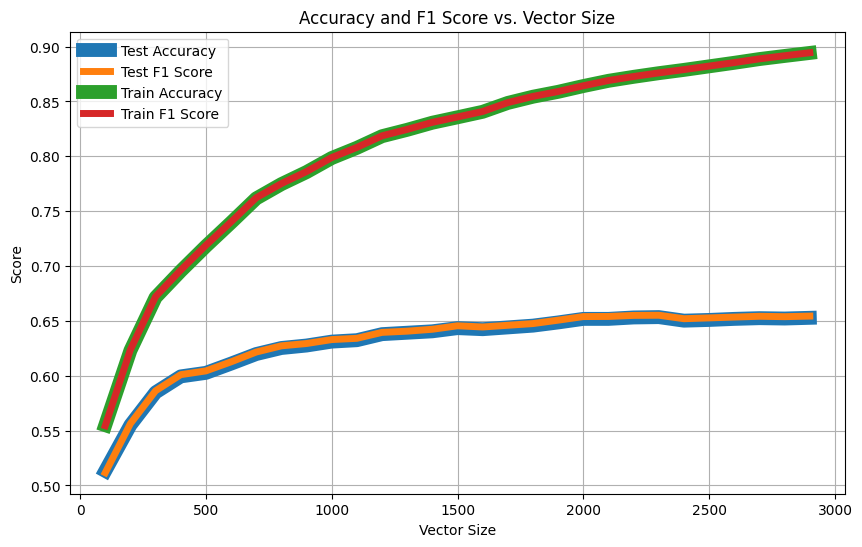

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['vector_size'], results_df['test_accuracy'], label='Test Accuracy', linewidth=10)
plt.plot(results_df['vector_size'], results_df['test_f1_score'], label='Test F1 Score', linewidth=5)
plt.plot(results_df['vector_size'], results_df['train_accuracy'], label='Train Accuracy', linewidth=10)
plt.plot(results_df['vector_size'], results_df['train_f1_score'], label='Train F1 Score', linewidth=5)
plt.xlabel('Vector Size')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Vector Size')
plt.legend()
plt.grid(True)
plt.show()

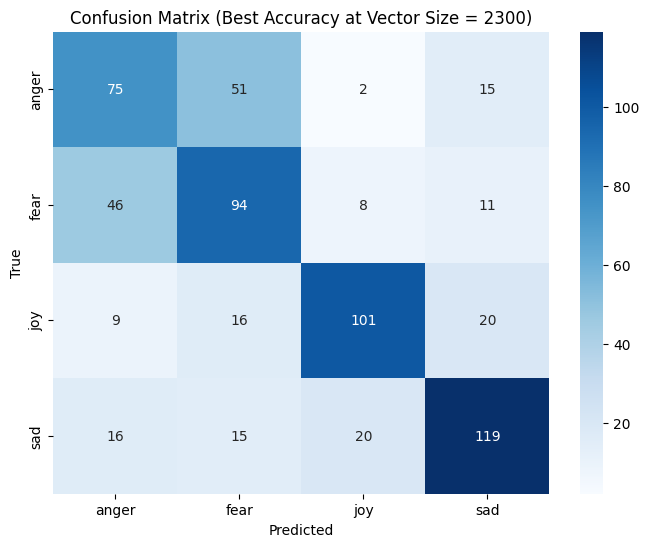

In [ ]:
best_vector_size = 2300

top_tokens = [token[0] for token in sorted_tokens[:best_vector_size]]
X_train = data.loc[train_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
y_train = data.loc[train_index, 'sentiment'].to_list()
X_test = data.loc[test_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
y_test = data.loc[test_index, 'sentiment'].to_list()

y_pred = simple_bayes_classifier(X_train, y_train, X_test, top_tokens)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Best Accuracy at Vector Size = {best_vector_size})')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['processed_text'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6504854368932039
              precision    recall  f1-score   support

       anger       0.64      0.50      0.56       156
        fear       0.56      0.68      0.62       164
         joy       0.84      0.60      0.70       144
         sad       0.64      0.81      0.72       154

    accuracy                           0.65       618
   macro avg       0.67      0.65      0.65       618
weighted avg       0.67      0.65      0.65       618

